# U.S. States 30×30 Policy Implementation and Progress Maps
---

This notebook presents a curated dataset of U.S. state-level 30×30 policy implementation and progress, compiled by the author from publicly available primary sources. Policy information collected from multiple primary sources is joined with U.S. Census state boundaries and rendered as maps.


- `sources.py`: Policy records were collected by the author from publicly available primary sources and standardized into a single dataset 
- `mapping_utils.py`: Custom mapping utilities (checkerboard symbology for states with multiple policy classifications)

Notebook Author: Cassie Buhler

In [1]:
from cng.utils import *
from cng.h3 import *
from ibis import _
import ibis.selectors as s
import geopandas as gpd
import pandas as pd
from sources import *
from mapping_utils import *

con = ibis.duckdb.connect(extensions = ["spatial"])
endpoint = os.getenv("AWS_S3_ENDPOINT", "minio.carlboettiger.info")
duckdb_install_h3()

set_secrets(con)

# Loading data, creating one dataframe
- `sources.py` contains dicts with sources
- I added polygons to each state

In [2]:
# imported from sources.py
impl_df = pd.DataFrame(implementation_sources)
prog_df = pd.DataFrame(progress_sources)

# joining into single dataframe 
df = impl_df.merge(
    prog_df,
    on="state_id",
    how="outer",
    validate="m:m"
)

# adding polygon boundaries for states using Census data
census_url = 's3://public-census/2024/state/2024_us_state.parquet'
polys = con.read_parquet(census_url).select('state_id','geom').filter(~_.state_id.isin(['AS','DC','GU','MP','PR','VI'])).execute()
bounds = [-170.0, 18.0, -65.0, 72.0]

gdf = df.merge(polys, on="state_id", how="outer").set_geometry('geom').set_crs("EPSG:4326")

# saving dataset 
gdf.to_parquet('30x30_states.parquet') 

# Visualizations

## Mapping implementation type 

In [3]:
impl_gdf = gdf.drop(columns=['progress_type','progress_notes','progress_citation','progress_url'])

# splitting up geometries for states that have multiple entries to map as a checkboard pattern 
impl_gdf = checkerboard_geom(impl_gdf,type_col="implementation_type",tile_m=80_000)

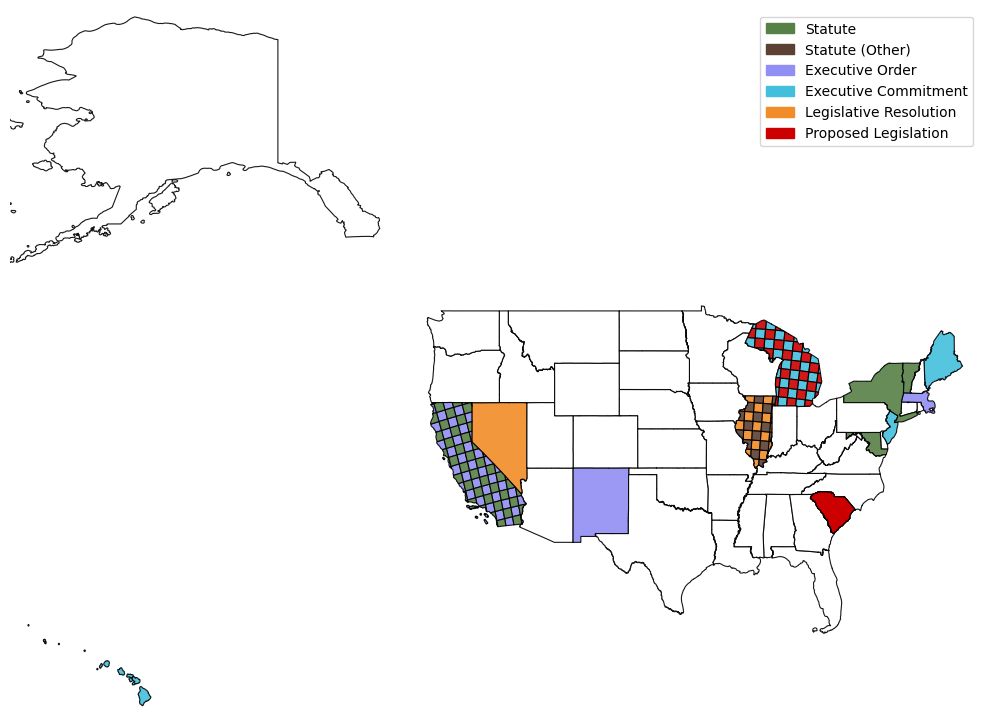

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

legend_dict = {
    "Statute": "#568046",
    "Statute (Other)": "#5C4033",
    "Executive Order": "#918EF4", 
    "Executive Commitment": "#42BFDD",
    "Legislative Resolution": "#F28C28", 
    "Proposed Legislation": "#CC0000",
}


impl_gdf["color"] = impl_gdf["implementation_type"].map(legend_dict).fillna("#FFFFFF")

fig, ax = plt.subplots(figsize=(10, 10))

# Fill
impl_gdf.plot(
    ax=ax,
    color=impl_gdf["color"],
    edgecolor="#000000",
    linewidth=0.8,
    alpha=0.9,
)

# Legend
handles = [mpatches.Patch(color=c, label=k) for k, c in legend_dict.items()]
ax.legend(handles=handles, loc="upper right", frameon=True)

# Fit bounds
minx, miny, maxx, maxy = bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_axis_off()
plt.tight_layout()
plt.savefig("30x30_state_implementation.png", dpi=400)
plt.show()


## Mapping progress type 

In [5]:
prog_gdf = gdf.drop(columns=['implementation_type','implementation_notes','implementation_citation','implementation_url'])

# splitting up geometries for states that have multiple entries to map as a checkboard pattern 
prog_gdf = checkerboard_geom(prog_gdf, type_col="progress_type",tile_m=80_000)

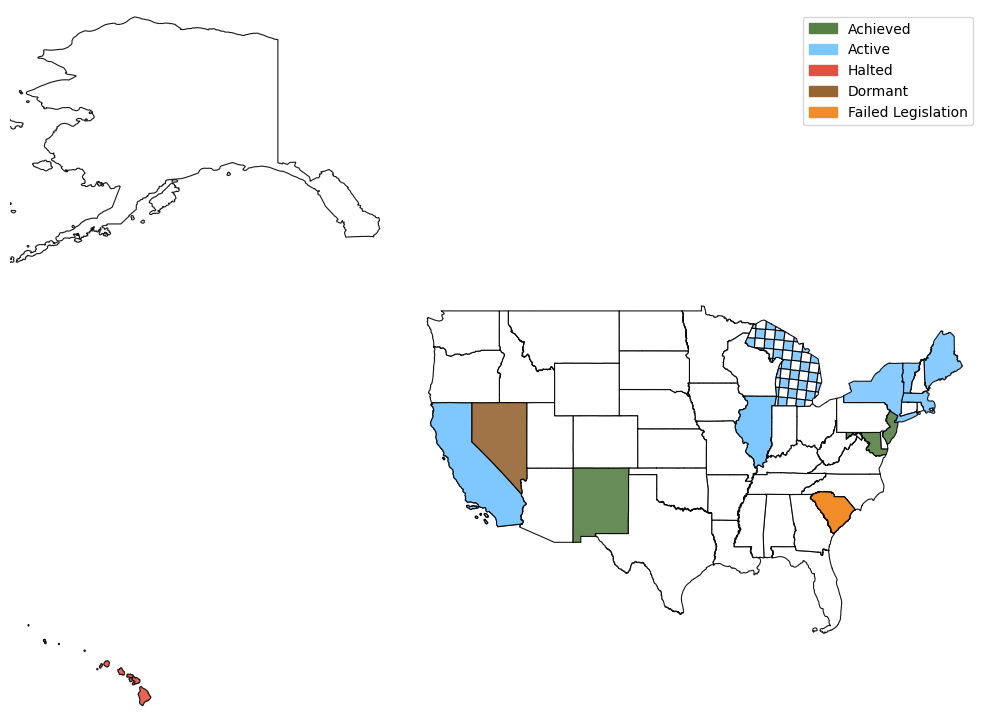

In [6]:
legend_dict = {
    "Achieved": "#568046",
    "Active": "#7DC7FF",
    "Halted": "#E05241",
    "Dormant": "#966532",
    "Failed Legislation": "#F28C28",
}

prog_gdf["color"] = prog_gdf["progress_type"].map(legend_dict).fillna("#FFFFFF")

fig, ax = plt.subplots(figsize=(10, 10))

# Fill
prog_gdf.plot(
    ax=ax,
    color=prog_gdf["color"],
    edgecolor="#000000",
    linewidth=0.8,
    alpha=0.9,
)

# Legend
handles = [mpatches.Patch(color=c, label=k) for k, c in legend_dict.items()]
ax.legend(handles=handles, loc="upper right", frameon=True)

# Fit bounds
minx, miny, maxx, maxy = bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_axis_off()
plt.tight_layout()
plt.savefig("30x30_state_progress.png", dpi=400)
plt.show()
